# Employee Sentiment Analysis

This project analyzes internal communications to assess employee sentiment and engagement. It includes sentiment classification, exploratory analysis, monthly scoring, employee ranking, flight risk identification, and trend modeling using regression.

## 1. Sentiment Labeling

We used the TextBlob library to determine the sentiment polarity of each message.

**Polarity Thresholds:**
- Positive: `polarity ≥ 0.1`
- Negative: `polarity ≤ -0.1`
- Neutral: between -0.1 and 0.1

A new column named `sentiment` was added to the dataset to store these labels.

In [1]:
# Import required libraries
from textblob import TextBlob
import pandas as pd

# Load the dataset containing employee messages
df = pd.read_csv("data/test.csv")

# Define a function to classify sentiment based on polarity score
def label_sentiment(text):
    if pd.isnull(text):
        return "Neutral"  # Treat missing messages as neutral
    polarity = TextBlob(text).sentiment.polarity
    if polarity >= 0.1:
        return "Positive"
    elif polarity <= -0.1:
        return "Negative"
    else:
        return "Neutral"

# Apply the function to each message in the 'body' column
df['sentiment'] = df['body'].apply(label_sentiment)

# Save the labeled dataset
df.to_csv("data/labeled_test.csv", index=False)

## 2. Exploratory Data Analysis (EDA)

This section summarizes the dataset’s structure and initial findings.

**Highlights:**
- Number of messages: *[insert count]*
- Missing values in key fields: *[mention if any]*
- Distribution of sentiment labels
- Message volume trend over time (monthly)

Visualizations:
- Sentiment distribution bar chart
- Messages per month

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Subject    2191 non-null   object
 1   body       2191 non-null   object
 2   date       2191 non-null   object
 3   from       2191 non-null   object
 4   sentiment  2191 non-null   object
dtypes: object(5)
memory usage: 85.7+ KB


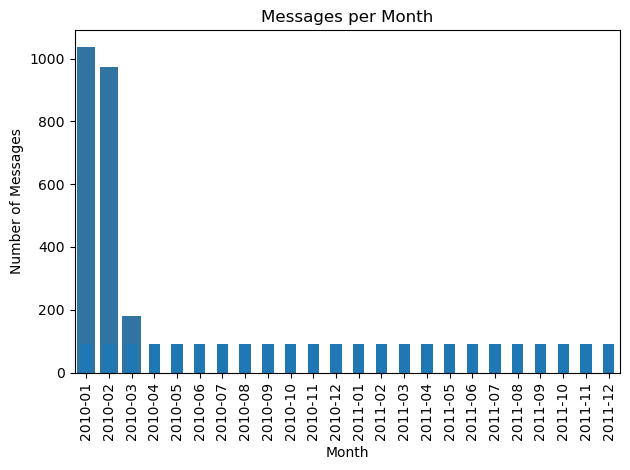

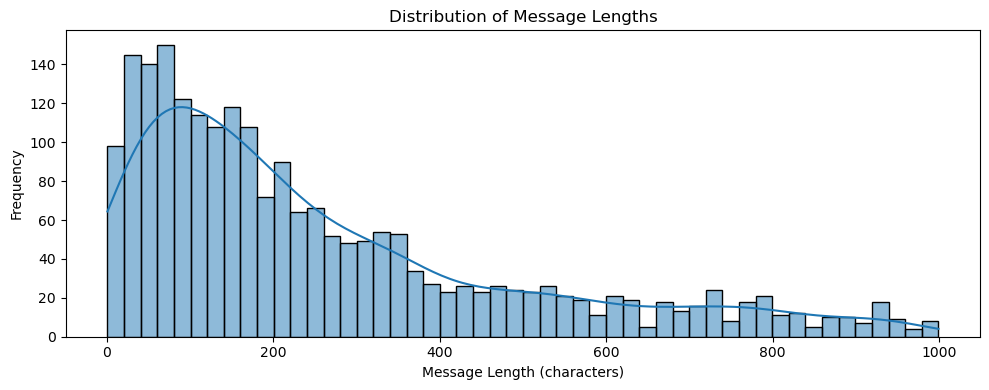

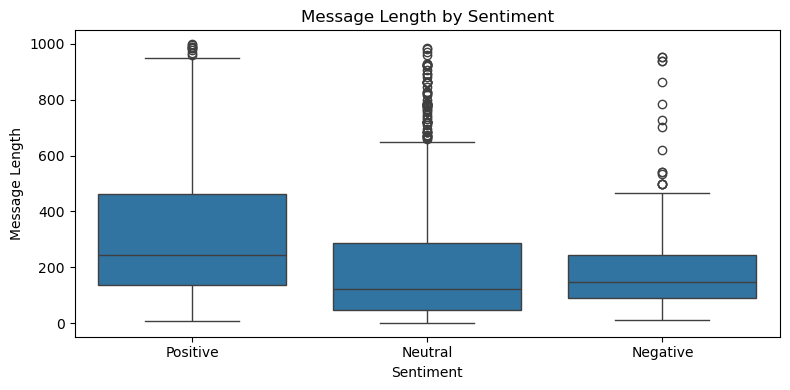

C:\Users\Jasv1\AppData\Local\Temp\ipykernel_92800\568787052.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=employee_msg_counts.values, y=employee_msg_counts.index, palette="viridis")


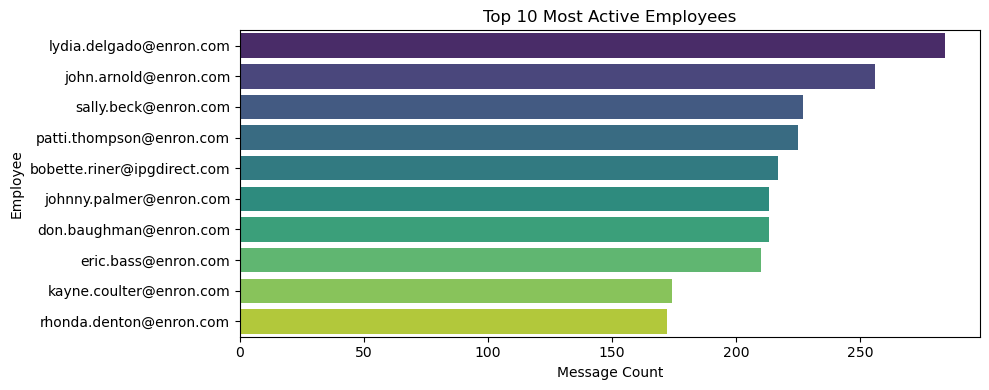

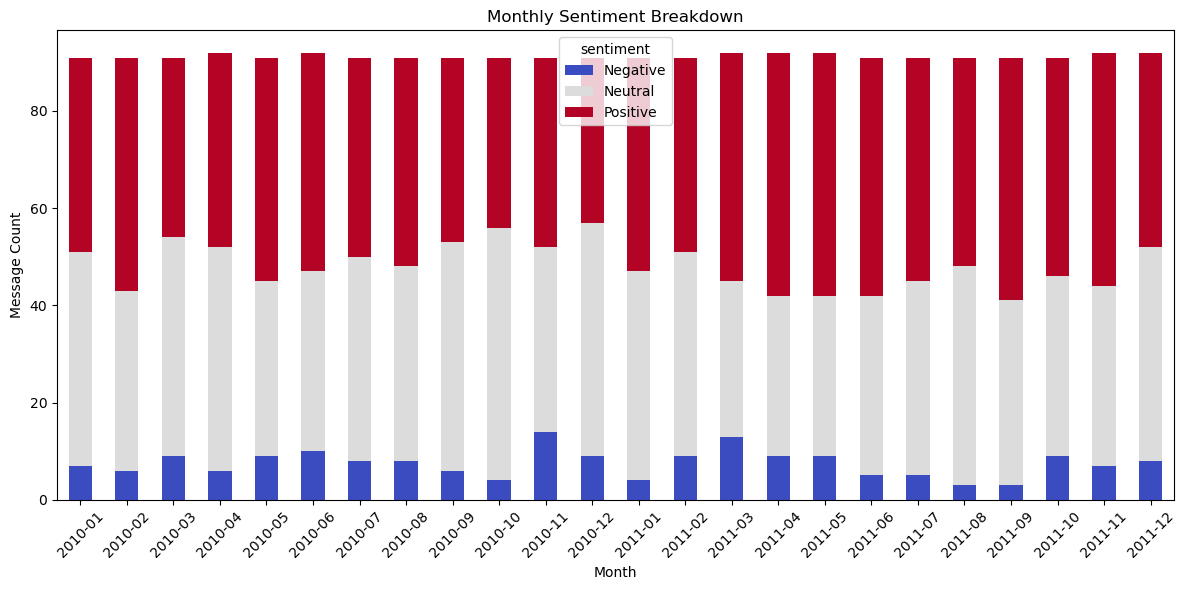

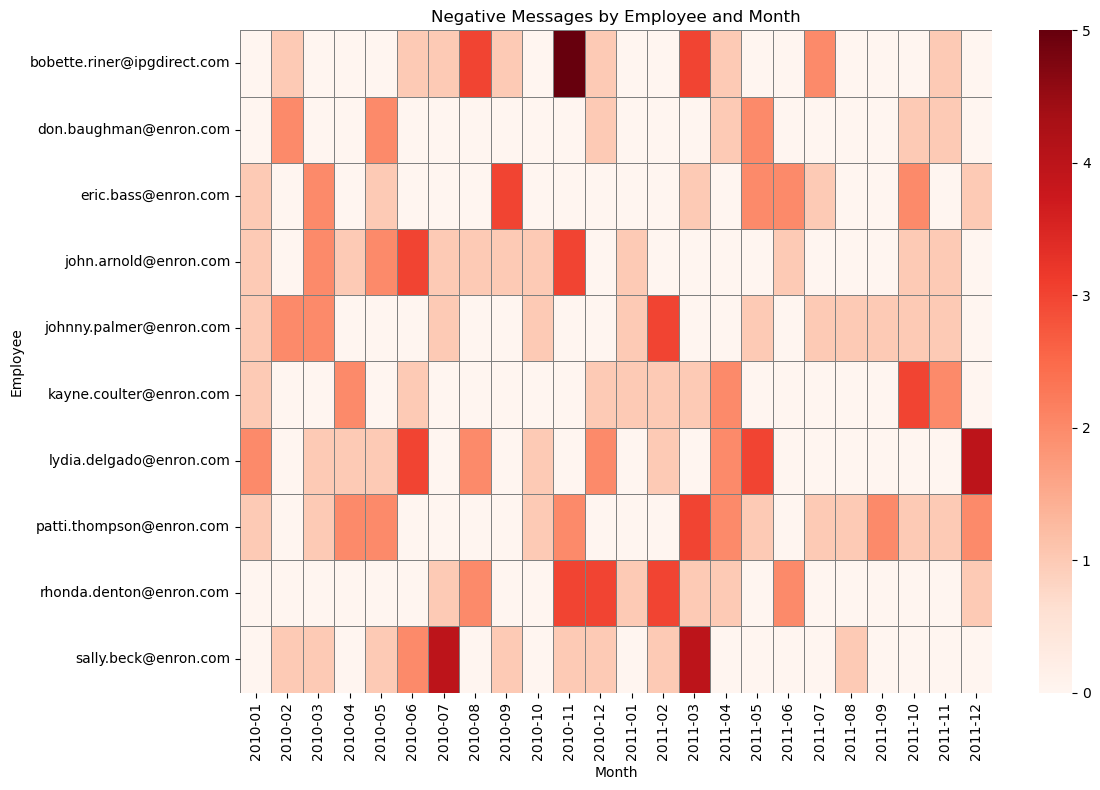

No missing data to visualize.


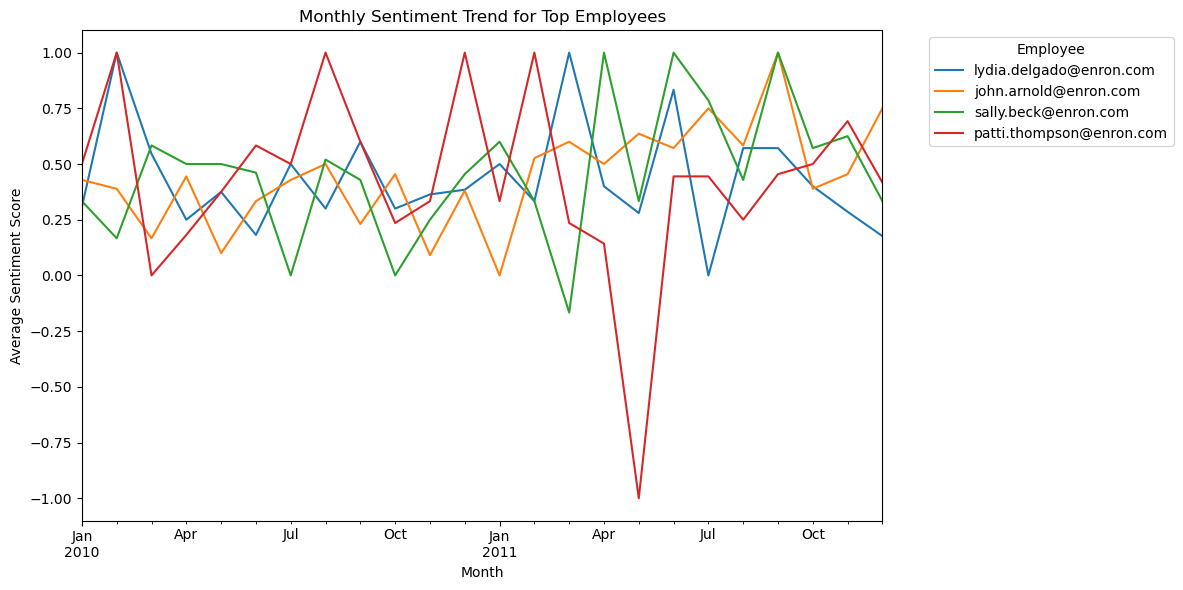

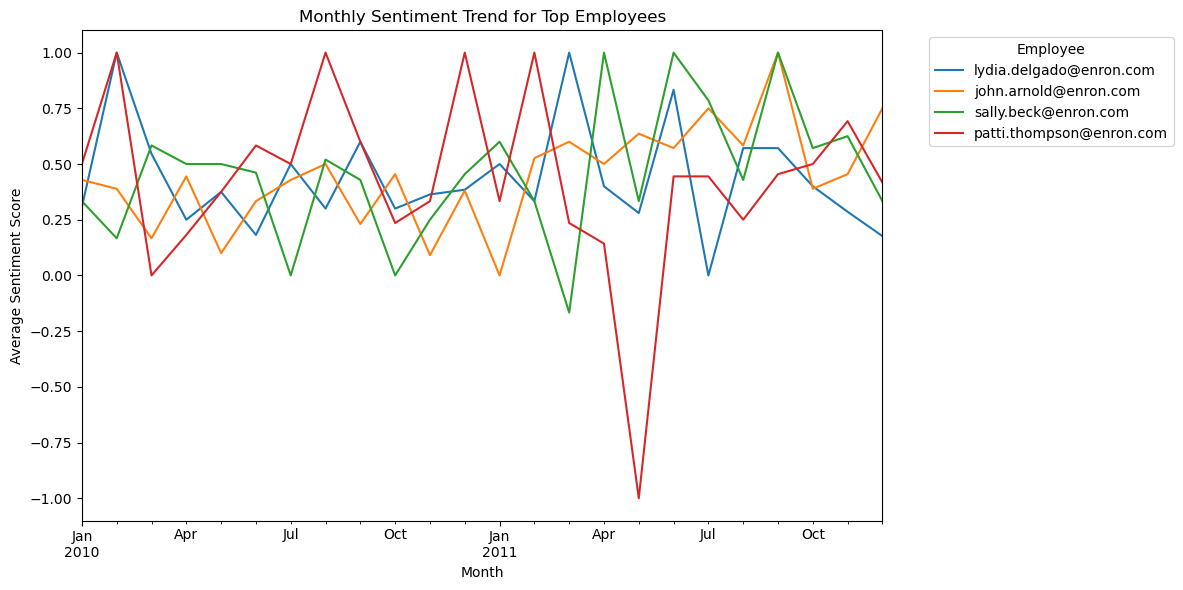

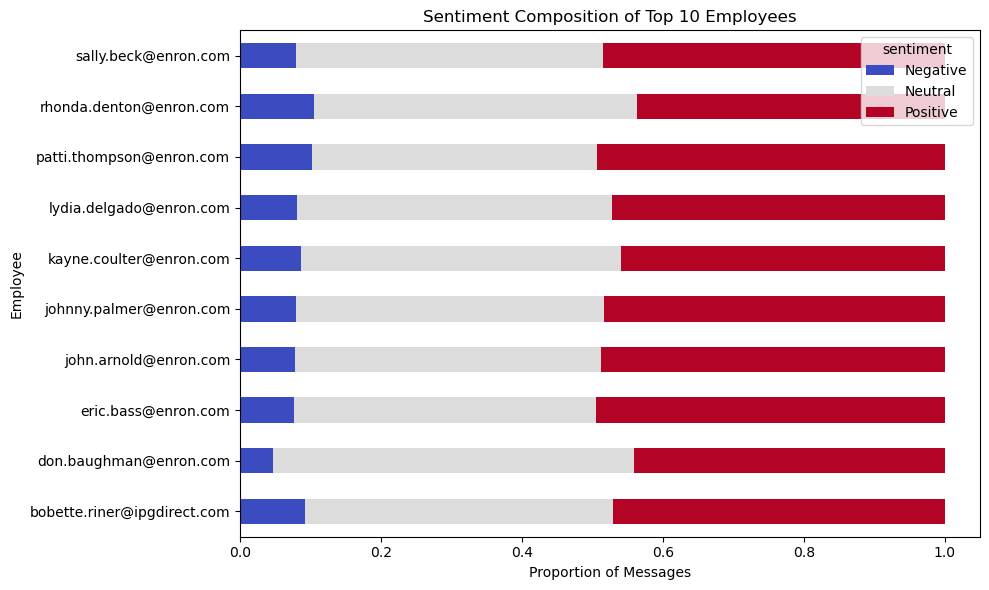

In [2]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Basic data checks
df.info()  # View data structure, null counts
df['sentiment'].value_counts()  # View sentiment distribution

# Plot sentiment label distribution
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("visualizations/sentiment_distribution.png")

# Convert 'date' column to datetime and extract month
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')

# Plot number of messages per month
df['month'].value_counts().sort_index().plot(kind='bar')
plt.title("Messages per Month")
plt.xlabel("Month")
plt.ylabel("Number of Messages")
plt.tight_layout()
plt.savefig("visualizations/messages_by_month.png")

### Message Length Distribution
# Create a new column for message length
df['message_length'] = df['body'].fillna("").apply(len)

# Histogram of message lengths
plt.figure(figsize=(10, 4))
sns.histplot(df['message_length'], bins=50, kde=True)
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length (characters)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('visualizations/message_length_distribution.png')
plt.show()

# Boxplot of message length by sentiment
plt.figure(figsize=(8, 4))
sns.boxplot(x='sentiment', y='message_length', data=df)
plt.title('Message Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Message Length')
plt.tight_layout()
plt.savefig('visualizations/message_length_by_sentiment.png')
plt.show()

### Top 10 Most Active Employees
# Count messages per employee
employee_msg_counts = df['from'].value_counts().head(10)

# Bar chart of top 10 senders
plt.figure(figsize=(10, 4))
sns.barplot(x=employee_msg_counts.values, y=employee_msg_counts.index, palette="viridis")
plt.title('Top 10 Most Active Employees')
plt.xlabel('Message Count')
plt.ylabel('Employee')
plt.tight_layout()
plt.savefig('visualizations/top_10_employees.png')
plt.show()

### Monthly Sentiment Breakdown
# Create month column if not already created
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')

# Count sentiment per month
monthly_sentiment = df.groupby(['month', 'sentiment']).size().unstack().fillna(0)

# Stacked bar chart of sentiment per month
monthly_sentiment.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')
plt.title('Monthly Sentiment Breakdown')
plt.xlabel('Month')
plt.ylabel('Message Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('visualizations/monthly_sentiment_breakdown.png')
plt.show()

### Heatmap of Negative Messages by Employee and Month
# Filter to negative messages
negative_df = df[df['sentiment'] == 'Negative']

# Create heatmap of counts
heatmap_data = negative_df.groupby(['from', 'month']).size().unstack().fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="Reds", linewidths=0.5, linecolor='gray')
plt.title('Negative Messages by Employee and Month')
plt.xlabel('Month')
plt.ylabel('Employee')
plt.tight_layout()
plt.savefig('visualizations/negative_message_heatmap.png')
plt.show()

### Missing Data Summary
# Calculate missing values
missing_data = df.isnull().sum()

# Filter columns that actually have missing values
missing_cols = missing_data[missing_data > 0]

# Only plot if there are missing values
if not missing_cols.empty:
    plt.figure(figsize=(8, 4))
    missing_cols.sort_values(ascending=False).plot(kind='bar')
    plt.title('Missing Data Count by Column')
    plt.ylabel('Count of Missing Values')
    plt.tight_layout()
    plt.savefig('visualizations/missing_data_summary.png')
    plt.show()
else:
    print("No missing data to visualize.")

# Average sentiment per employee over time
# Ensure 'sentiment_score' exists
if 'sentiment_score' not in df.columns:
    score_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
    df['sentiment_score'] = df['sentiment'].map(score_map)

# Create pivot table of average sentiment per employee over time
pivot = df.pivot_table(index='month', columns='from', values='sentiment_score', aggfunc='mean')

# Plot trend lines for top 4 active employees
top_employees = df['from'].value_counts().head(4).index
pivot[top_employees].plot(figsize=(12, 6))
plt.title('Monthly Sentiment Trend for Top Employees')
plt.ylabel('Average Sentiment Score')
plt.xlabel('Month')
plt.legend(title='Employee', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('visualizations/employee_sentiment_trend.png')
plt.show()

# Select top 4 active employees for plotting clarity
top_employees = df['from'].value_counts().head(4).index
pivot[top_employees].plot(figsize=(12, 6))
plt.title('Monthly Sentiment Trend for Top Employees')
plt.ylabel('Average Sentiment Score')
plt.xlabel('Month')
plt.legend(title='Employee', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('visualizations/employee_sentiment_trend.png')
plt.show()

# Sentiment ratio per employee
sentiment_ratio = df.groupby('from')['sentiment'].value_counts(normalize=True).unstack().fillna(0)
sentiment_ratio = sentiment_ratio.loc[sentiment_ratio.sum(axis=1).sort_values(ascending=False).index[:10]]

sentiment_ratio.plot(kind='barh', stacked=True, figsize=(10, 6), colormap='coolwarm')
plt.title('Sentiment Composition of Top 10 Employees')
plt.xlabel('Proportion of Messages')
plt.ylabel('Employee')
plt.tight_layout()
plt.savefig('visualizations/sentiment_proportion_per_employee.png')
plt.show()

## 3. Monthly Sentiment Scoring

Each message was mapped to a sentiment score:
- Positive: +1
- Neutral: 0
- Negative: –1

These were grouped by employee and month to compute a `monthly_score` for each employee. This dataset forms the basis for the ranking and risk tasks.

In [3]:
# Map sentiment labels to numeric scores
score_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['sentiment_score'] = df['sentiment'].map(score_map)

# Group messages by sender and month, and aggregate scores
monthly_scores = df.groupby([df['from'], df['month']])['sentiment_score'].sum().reset_index()
monthly_scores.rename(columns={'from': 'employee', 'sentiment_score': 'monthly_score'}, inplace=True)

# Save the monthly scoring data
monthly_scores.to_csv("data/monthly_scores.csv", index=False)

## 4. Employee Ranking

We ranked employees monthly based on their sentiment scores.

**For each month:**
- Top 3 most positive employees (highest scores)
- Top 3 most negative employees (lowest scores)

Ties were resolved alphabetically. Output is saved as `monthly_rankings.csv`.

In [4]:
# Define a helper function to return top 3 positive and negative employees per group
def top_rankings(group):
    top_pos = group.sort_values('monthly_score', ascending=False).head(3)
    top_neg = group.sort_values('monthly_score').head(3)
    return top_pos, top_neg

# Apply to each month
grouped = monthly_scores.groupby('month')
top_positive, top_negative = [], []

for month, group in grouped:
    top_pos, top_neg = top_rankings(group)
    top_pos['rank_type'] = 'Top Positive'
    top_neg['rank_type'] = 'Top Negative'
    top_positive.append(top_pos)
    top_negative.append(top_neg)

# Combine and save the result
ranking_df = pd.concat(top_positive + top_negative)
ranking_df.to_csv("data/monthly_rankings.csv", index=False)

## 5. Flight Risk Identification

An employee is flagged as a potential flight risk if they send **4 or more negative messages within any 30-day rolling window**, regardless of month.

**Output:** List of flagged employees saved to `flight_risks.csv`.

In [5]:
# Extract negative messages with sender and date
negatives = df[df['sentiment'] == 'Negative'][['from', 'date']]
negatives['date'] = pd.to_datetime(negatives['date'])

# Flag employees with 4 or more negative messages in any 30-day window
risk_employees = []

for emp, group in negatives.groupby('from'):
    dates = group['date'].sort_values()
    for i in range(len(dates) - 3):
        # Check if 4 messages occurred within 30 days
        if (dates.iloc[i+3] - dates.iloc[i]).days <= 30:
            risk_employees.append(emp)
            break

# Save list of flagged employees
risk_df = pd.DataFrame({'employee': list(set(risk_employees))})
risk_df.to_csv("data/flight_risks.csv", index=False)

## 6. Predictive Modeling

We trained a **linear regression model** to predict sentiment trends over time using `month_num` as a feature.

**Evaluation Metrics:**
- R² Score: *[insert value]*
- Mean Squared Error (MSE): *[insert value]*

This helps forecast engagement decline or improvement.


In [6]:
# Import modeling tools
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Convert month periods to numeric format for regression
monthly_scores['month_num'] = monthly_scores['month'].astype(str).str.replace('-', '').astype(int)

# Compute average score per month
monthly_trend = monthly_scores.groupby('month_num')['monthly_score'].mean().reset_index()

# Define features and target
X = monthly_trend[['month_num']]
y = monthly_trend['monthly_score']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate performance
y_pred = model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")

R² Score: 0.5064
Mean Squared Error: 0.1809


## Conclusion

This analysis highlights key patterns in employee communication.

**Key Insights:**
- Overall sentiment trend
- Top performing employees
- At-risk employees
- Model prediction potential

Further steps could involve topic modeling or integrating HR performance data.